## Collect Images with Webcam using OpenCV

In [109]:
import os
import time
import uuid #allows us to easily create uniform unique identifiers for the images
import cv2

In [57]:
IMAGES_PATH = os.path.join('data','images')
number_images = 40

In [13]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(1)

    if cv2.waitKey(1) == 13: 
        break
        
cap.release()
cv2.destroyAllWindows()

## Annotate Images (draw bounding boxes) using LabelMe

In [95]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: C:\Users\Bir\.labelmerc
[WARNING] label_file:load:92 - Loading JSON file (C:/Users/Bir/Documents/Job 22/Tensorflow/aug_data/test/labels\0cb7034c-2a1e-11ed-82be-c4346b274265_0.json) of unknown version


## Increase size of dataset by augmenting images using Albumentations

In [110]:
import tensorflow as tf
import json  #labels are in .json format
import numpy as np
from matplotlib import pyplot as plt

Load Image into TF Data Pipeline

In [20]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg', shuffle=False)   #* is wildcard search. It means we want all .jpg files 

In [6]:
#keep running as_numpy_iterator().next() to loop through all the samples
images.as_numpy_iterator().next()     #this returns path to a random image. Use this to test if the image paths loaded correctly

b'data\\images\\a584b774-2a1d-11ed-a897-c4346b274265.jpg'

In [59]:
#function to load image from a filepath
def load_image(x): 
    byte_img = tf.io.read_file(x)     #takes the filepath and returns a byte encoded image
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)    #map allows us to apply a function to every element of a dataset. So we are applying load_image function to every element of images (dataset of filepaths), which will convert them all from filepaths to the actual images

In [9]:
images.as_numpy_iterator().next()    #test to see if we can return an image

array([[[182, 183, 185],
        [181, 182, 184],
        [181, 183, 182],
        ...,
        [141,  56,   2],
        [137,  54,   0],
        [134,  51,   0]],

       [[181, 182, 184],
        [181, 182, 184],
        [182, 184, 183],
        ...,
        [140,  55,   1],
        [135,  52,   0],
        [133,  50,   0]],

       [[181, 183, 182],
        [182, 184, 183],
        [182, 184, 183],
        ...,
        [139,  54,   0],
        [135,  53,   0],
        [133,  51,   0]],

       ...,

       [[154, 166, 162],
        [154, 166, 162],
        [154, 166, 162],
        ...,
        [ 66,  72,  70],
        [ 67,  73,  71],
        [ 68,  74,  72]],

       [[153, 165, 161],
        [152, 164, 160],
        [152, 164, 160],
        ...,
        [ 66,  72,  70],
        [ 66,  72,  70],
        [ 66,  72,  70]],

       [[151, 163, 159],
        [151, 163, 159],
        [152, 164, 160],
        ...,
        [ 65,  71,  69],
        [ 64,  70,  68],
        [ 63,  69,  67]]

Visualise raw images with Matplotlib

In [11]:
image_generator = images.batch(4).as_numpy_iterator()    #tensorflow batch function used to batch images up into groups of 4

In [18]:
plot_images = image_generator.next()    #retuns a new batch of data every time this is run

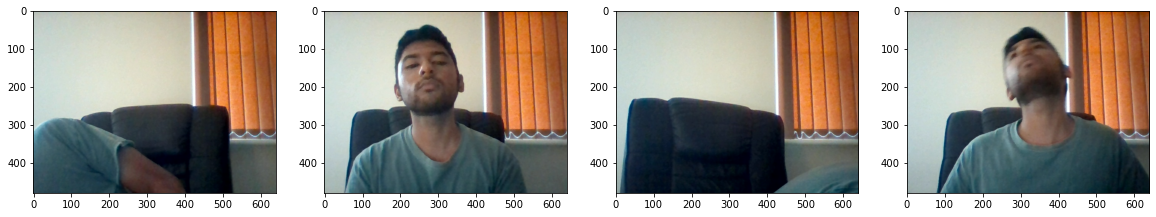

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

Split images into train, test, validation folders

In [26]:
import splitfolders    #inside images folder, there needs to be subfolders for each class for this to work. Since we only have one class, we created another folder inside the images folder, and put all the images in there (if we had 2 classes red and blue, the folder structure would be images->blue with all blue images inside and images->red with all red images inside)

In [30]:
splitfolders.ratio(IMAGES_PATH, output="output", seed=1337, ratio=(.7, 0.15,0.15))

Copying files: 90 files [00:00, 355.89 files/s]


Inside train, test, and validation folders, create image and label subfolders. The below code will add the labels to the correct folders based on which dataset their corresponding image is in

In [31]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)   

Now we can setup the Albumentations transform pipeline

In [33]:
import albumentations as alb

In [92]:
#from albumentations documentation
#different bounding box parameter formats. We are using albumentation format, which is scaled to the size of the image (so are between 0-1). So x or y is the raw coordinate divided by width or height of image respectively
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.4), 
                         alb.RandomBrightnessContrast(p=0.33),
                         alb.RandomGamma(p=0.33), 
                         alb.RGBShift(p=0.33), 
                         alb.VerticalFlip(p=0.25)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [64]:
#load a random image to see how it will be augmented, and its corresponding label
img = cv2.imread(os.path.join('data','test', 'images','0cb7034c-2a1e-11ed-82be-c4346b274265.jpg')) 

with open(os.path.join('data', 'test', 'labels', '0cb7034c-2a1e-11ed-82be-c4346b274265.json'), 'r') as f:
    label = json.load(f)

In [65]:
img.shape #current size

(480, 640, 3)

In [66]:
label

{'version': '5.0.1',
 'flags': {},
 'shapes': [{'label': 'face',
   'points': [[189.17518248175182, 24.54744525547445],
    [384.0656934306569, 253.74452554744525]],
   'group_id': None,
   'shape_type': 'rectangle',
   'flags': {}}],
 'imagePath': '..\\images\\0cb7034c-2a1e-11ed-82be-c4346b274265.jpg',
 'imageData': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAHgAoADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZH

In [67]:
#label is a dictionary, so we can grab the label or the points from it
label['shapes'][0]['label']

'face'

In [68]:
label['shapes'][0]['points']

[[189.17518248175182, 24.54744525547445],
 [384.0656934306569, 253.74452554744525]]

We need to extract the coordinates of the bounding box and store them into a coordinates array

In [69]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0] #x1
coords[1] = label['shapes'][0]['points'][0][1] #y1
coords[2] = label['shapes'][0]['points'][1][0] #x2
coords[3] = label['shapes'][0]['points'][1][1] #y2

In [70]:
coords

[189.17518248175182, 24.54744525547445, 384.0656934306569, 253.74452554744525]

In [71]:
#Now will convert the coordinates to albumentation format by dividing x by the width, and y by the height of the image
coords = list(np.divide(coords, [640,480,640,480]))
coords

[0.2955862226277372,
 0.05114051094890511,
 0.6001026459854014,
 0.5286344282238443]

Now lets run this image and this label coordinates through the augmentor

In [78]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [79]:
augmented

{'image': array([[[ 29,  51, 109],
         [ 33,  50, 101],
         [ 34,  50,  93],
         ...,
         [194, 202, 192],
         [197, 201, 195],
         [197, 201, 195]],
 
        [[ 33,  53, 111],
         [ 33,  50, 101],
         [ 33,  49,  92],
         ...,
         [197, 202, 193],
         [197, 202, 193],
         [198, 202, 196]],
 
        [[ 35,  54, 111],
         [ 34,  49,  98],
         [ 34,  47,  91],
         ...,
         [196, 201, 192],
         [197, 202, 193],
         [199, 202, 193]],
 
        ...,
 
        [[ 48,  37,  23],
         [ 48,  37,  23],
         [ 49,  38,  24],
         ...,
         [164, 168, 157],
         [165, 169, 158],
         [164, 168, 157]],
 
        [[ 48,  38,  21],
         [ 48,  38,  21],
         [ 49,  38,  24],
         ...,
         [164, 167, 158],
         [164, 168, 157],
         [164, 168, 157]],
 
        [[ 48,  38,  21],
         [ 48,  38,  21],
         [ 49,  38,  24],
         ...,
         [164, 167,

In [73]:
#augmented is a dictionary. This is how we would return xmax and ymax from it
augmented['bboxes'][0][2:]

(0.6107218167072181, 0.5438767234387673)

In [74]:
#this is how we would return all the bounding box coordinates
augmented['bboxes']

[(0.177631792376318,
  0.03454987834549878,
  0.6107218167072181,
  0.5438767234387673)]

In [82]:
#shows that the crop has worked. Image now 450x450
augmented['image'].shape

(450, 450, 3)

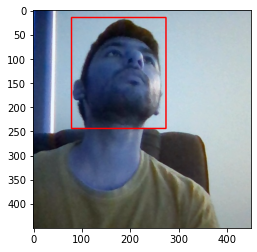

In [75]:
#will now visualise the augmented image with the adjusted bounding box
#cv2.rectangle allows us to draw the bounding box onto the image
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)   #colour, 2 is thickness of bounding box

plt.imshow(augmented['image'])

#image appears blue because opencv reads image as bgr, but matplotlib reads it as rgb

We have successfully augmented one image. Now we will build a pipeline to augment all the images

In [96]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]     #default bb coordinates if there is no bb (no face in image, so no label)
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):     #if a label exists, get the correct coordinates of bb
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):     #creating 60 augmented images for every base image
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}_{x}.jpg'), augmented['image']) #save augmented images in "aug_data" folder

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}_{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
            print(image)

Now that the images have been augmented we can load them to a tensorflow dataset

In [60]:
#need shuffle=False so labels will be in the same order as corresponding image
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False) #same as above
train_images = train_images.map(load_image) #same as above
#compress images to 120x120- makes neural network more efficient without affecting performance
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120))) #map needs to be used with a function. Instead of defining a resize function, we can just write in a lambda python
#scale image values, so instead of being between 0-255, they will be between 0-1, so we can apply sigmooid activation to final layer of neural network
train_images = train_images.map(lambda x: x/255)

In [61]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [62]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [102]:
train_images.as_numpy_iterator().next()

array([[[8.4460783e-01, 3.2303920e-01, 1.8137256e-02],
        [8.6311275e-01, 3.4546569e-01, 2.3406863e-02],
        [8.3725488e-01, 3.1960785e-01, 0.0000000e+00],
        ...,
        [8.0851716e-01, 7.1832108e-01, 6.6341913e-01],
        [8.0196077e-01, 7.1783090e-01, 6.5649509e-01],
        [7.9111522e-01, 7.1366423e-01, 6.4699757e-01]],

       [[8.4430146e-01, 3.2322302e-01, 2.9105391e-02],
        [8.4350491e-01, 3.2634804e-01, 4.7794119e-03],
        [8.4362745e-01, 3.2696077e-01, 5.5147061e-04],
        ...,
        [8.1176472e-01, 7.2696078e-01, 6.7205882e-01],
        [8.0269605e-01, 7.2689950e-01, 6.6899508e-01],
        [8.0079657e-01, 7.2567403e-01, 6.6194850e-01]],

       [[8.5863972e-01, 3.4540442e-01, 6.1580881e-02],
        [8.8419116e-01, 3.7444854e-01, 7.4387252e-02],
        [8.6868870e-01, 3.5624999e-01, 3.4252450e-02],
        ...,
        [8.1427693e-01, 7.3976713e-01, 6.8486518e-01],
        [8.1127453e-01, 7.3676473e-01, 6.8186277e-01],
        [8.0882353e-01

And now we can load the labels to a tensorflow dataset

In [63]:
#label loading function
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    #we want to extract the class and bbox coordinates from the label    
    return [label['class']], label['bbox'] #returns 2 arrays. First has class, second has bbox coordinates

In [64]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [65]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [66]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [107]:
train_labels.as_numpy_iterator().next()
#1 in first array means face present. 0 means no face present.

(array([1], dtype=uint8),
 array([0.4866, 0.2727, 0.8433, 0.7417], dtype=float16))

For other ml libraries eg sklearn, we keep data and labels seperate, but for tensorflow we combine them. So now we will combine the image and label datasets

In [67]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3720, 3720, 840, 840, 840, 840)

In [68]:
train = tf.data.Dataset.zip((train_images, train_labels)) #zip combines each image sample with its corresponding label (since they are in the same order)
train = train.shuffle(5000) #shuffle buffer should be bigger than size of dataset
train = train.batch(8)
train = train.prefetch(4) #will grab the next dataset item "in advance" while the current one is being processed to reduce latency

In [69]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [70]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [71]:
#shows the size of a batch of images in the dataset. batches of 8, image is 120 x 120, 3 for rgb as its a coloured image
train.as_numpy_iterator().next()[0].shape #0 for images

(8, 120, 120, 3)

In [26]:
#show the labels and bbox for a batch 
train.as_numpy_iterator().next()[1] #1 for labels

(array([[0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1]], dtype=uint8),
 array([[0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.3293  , 0.602   ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.521   , 0.08844 , 1.      , 0.721   ],
        [0.4233  , 0.001995, 0.9     , 0.753   ],
        [0.      , 0.12463 , 0.6006  , 1.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.552   , 0.3154  , 0.8613  , 0.661   ]], dtype=float16))

Visualise these images and annotations

In [27]:
data_samples = train.as_numpy_iterator()

In [28]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


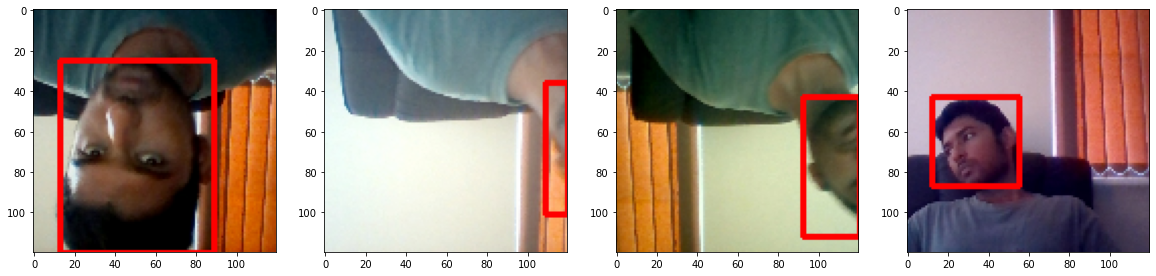

In [29]:
#visualise 4 images with their annotations
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## Use the Keras Functional API to build the model

In [72]:
from tensorflow.keras.models import Model #the base of all tf models
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [73]:
vgg = VGG16(include_top=False) #create VGG16 instance #include_top=False to remove final layers

In [74]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

The final output layer of the VGG16 model has been removed. We will now build on this model by adding on our 2 models. The first will be the classification model to determine whether a face is present or not. The second will be the bounding box model that will draw the bounding box onto an image, if a face is present.

In [75]:
def build_model(): 
    #start with input layer
    input_layer = Input(shape=(120,120,3)) #using Input class we imported. #our images are 120x120, 3 is RGB
    
    #after input layer move to vgg model, with final layers removed
    vgg = VGG16(include_top=False)(input_layer) #must specify the layer before afterwards (input_layer)

    #after vgg layers move to classification model 
    f1 = GlobalMaxPooling2D()(vgg) #condense all info from vgg layer using a GlobalMaxPooling2D layer
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1) #1 output of classification model. Sigmoid turns it into a value between 0-1 based on if a face is present
     
    #or after vgg layers move to regression bounding box model   
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) #4 outputs of regression model (4 corrdinates of bounding box). Sigmoid activation because our coordinates are scaled between 0-1 (because we divided them by the scale of the image)
    
    #combine everything using Model API we imported
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

Now we can build an instance of the model using the above function

In [76]:
facetracker = build_model()

In [77]:
facetracker.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_8[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_4 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

Let's give an example of how we would run this on an image (but we would normally do this after the model been trained)

In [78]:
X, y = train.as_numpy_iterator().next()    #X is the image, y is the 2 labels (face presence and bbox coordinates)

In [79]:
X #remember we have batches of 8

array([[[[0.6951593 , 0.7215074 , 0.6922181 ],
         [0.7188113 , 0.730576  , 0.69528186],
         [0.7205882 , 0.72843134, 0.6852941 ],
         ...,
         [0.53137255, 0.17156863, 0.07714461],
         [0.7481618 , 0.3584559 , 0.05747549],
         [0.76029414, 0.3528799 , 0.03995098]],

        [[0.7182598 , 0.7423407 , 0.7121936 ],
         [0.73045343, 0.74221814, 0.706924  ],
         [0.7378064 , 0.7461397 , 0.70398283],
         ...,
         [0.4978554 , 0.159375  , 0.0278799 ],
         [0.77224267, 0.3985294 , 0.11470588],
         [0.7908701 , 0.38841912, 0.09577206]],

        [[0.74264705, 0.76617646, 0.7269608 ],
         [0.7451593 , 0.7637868 , 0.7363358 ],
         [0.74895835, 0.76072305, 0.72542894],
         ...,
         [0.50104165, 0.16433823, 0.06231618],
         [0.7626838 , 0.39607844, 0.1567402 ],
         [0.77322304, 0.38596815, 0.08841912]],

        ...,

        [[0.64393383, 0.7066789 , 0.6949142 ],
         [0.6509804 , 0.71666664, 0.6936275 ]

In [80]:
y

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.3782 , 0.03995, 0.871  , 0.59   ],
        [0.291  , 0.1017 , 0.8164 , 0.6177 ],
        [0.3875 , 0.05496, 0.793  , 0.673  ],
        [0.1179 , 0.03223, 0.5347 , 0.5093 ],
        [0.097  , 0.03976, 0.5254 , 0.5977 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.3928 , 0.2263 , 1.     ],
        [0.94   , 0.2067 , 1.     , 0.7793 ]], dtype=float16))

In [81]:
classes, coords = facetracker.predict(X) #pass in a batch of images to the model

1/1 [==============================] - 6s 6s/step


In [82]:
classes, coords #the outputs of the model (classes = is face present, coord = bbox coordinates)

(array([[0.32012334],
        [0.41176257],
        [0.26240265],
        [0.35841808],
        [0.2597156 ],
        [0.3401643 ],
        [0.32731432],
        [0.29262167]], dtype=float32),
 array([[0.50938207, 0.43361688, 0.44815576, 0.49966818],
        [0.402706  , 0.42035002, 0.43127784, 0.41705948],
        [0.39440632, 0.5544739 , 0.4441715 , 0.5468503 ],
        [0.3822718 , 0.5705459 , 0.40658924, 0.39142078],
        [0.38513684, 0.5785171 , 0.43080643, 0.41262847],
        [0.35948634, 0.4058247 , 0.43190095, 0.36184752],
        [0.38051036, 0.4631251 , 0.38703755, 0.31808934],
        [0.34385088, 0.3864241 , 0.45122847, 0.38484403]], dtype=float32))

The model has been successfully built. Before training, we need to define a few things. First we must define the optimiser, lr, and rate of lr decay. Based on research, we should decay the learning rate at a rate so that is 75% of the original learning rate after each epoch. This helps to avoid overfitting and exploding gradients

In [83]:
batches_per_epoch = len(train) #number of batches in our training data 
lr_decay = (1./0.75 -1)/batches_per_epoch

In [84]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay) #using Adam optimiser

For the classificaton model we will use the BinaryCrossEntropyLoss as the loss function. But for the regression model will define our own localization loss function (based on how far the predicted bbox coordinates are from the actual bbox coordinates)

In [85]:
def localization_loss(y_true, yhat):           
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2])) #distance between actual coordinates and predicted coordinates (does both x and y)
                  
    h_true = y_true[:,3] - y_true[:,1] #actual height of box
    w_true = y_true[:,2] - y_true[:,0] #actual width of box

    h_pred = yhat[:,3] - yhat[:,1] #predicted height of box
    w_pred = yhat[:,2] - yhat[:,0] #predicted width of box
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [86]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss #assigning localization_loss function to the variable regressloss, so now calling regressloss() runs the function localization_loss 

In [87]:
#testing out classification model loss function
classloss(y[0], classes) #to just get the value add on .numpy() to end

<tf.Tensor: shape=(), dtype=float32, numpy=1.0624909>

In [88]:
#testing out regression model loss function
regressloss(y[1], coords) 

<tf.Tensor: shape=(), dtype=float32, numpy=5.8843317>

## Create a Training Pipeline to Train the Model

When subclassing the Model class from Keras, need to include an init method, compile method, train_step method, and call method

In [89]:
class FaceTracker(Model): #Model we imported from keras
    
    #in init method, pass through inital parameters. In this case the facetracker model (we built an instance of the model function earlier called facetracker)
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    #in compile method, pass through optimizer and loss functions
    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        #set the variables as class attributs so we can use them later
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): #takes in one batch of data at a time as input
        
        X, y = batch #unpack batch into X-image and y-labels
        
        with tf.GradientTape() as tape: #starts monitoring and calculating all the values and allows us to access them, since we need access to the gradients later in this step. We need to use this because we are doing a custom training step
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes) #calculated using predicted labels (classes) and actual labels (y[0])
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords) #this loss function only worked when we cast y[1] as a float32
            
            total_loss = batch_localizationloss+0.5*batch_classloss #combine the two loss function outputs to get one loss metric #0.5*classloss works well
            
            grad = tape.gradient(total_loss, self.model.trainable_variables) #calculating all gradients wrt our calculated loss
        
        #gradient descent
        opt.apply_gradients(zip(grad, self.model.trainable_variables)) #loop through each gradient, apply gradient descent to minimise the loss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    #same as train step, but using validation dataset, and no updating gradients
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    #needed so we can use model.predict
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [90]:
model = FaceTracker(facetracker) #create an instance of the training Facetracker class, passing through the model as parameter

In [91]:
model.compile(opt, classloss, regressloss) #run the compile function from the Facetracker class

Now we can train the model

In [92]:
logdir='logs'

In [93]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir) #in case we want to review model performance after training

In [94]:
#.fit triggers the training step. By passing through validation data it trigegrs the test step. (To only use a certain amount of training data, add in train.take(100)- use 100 training data)
#by assigning the model to a variable (in this case hist), we can see the history which we'll use to plot the performance
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
465/465 [==============================] - 1828s 4s/step - total_loss: 0.2782 - class_loss: 0.0644 - regress_loss: 0.2460 - val_total_loss: 0.0852 - val_class_loss: 0.0062 - val_regress_loss: 0.0821
Epoch 2/10
465/465 [==============================] - 1692s 4s/step - total_loss: 0.0887 - class_loss: 0.0264 - regress_loss: 0.0756 - val_total_loss: 0.0650 - val_class_loss: 0.0014 - val_regress_loss: 0.0643
Epoch 3/10
465/465 [==============================] - 1769s 4s/step - total_loss: 0.0536 - class_loss: 0.0144 - regress_loss: 0.0464 - val_total_loss: 0.0679 - val_class_loss: 0.0054 - val_regress_loss: 0.0652
Epoch 4/10
465/465 [==============================] - 1613s 3s/step - total_loss: 0.0258 - class_loss: 0.0065 - regress_loss: 0.0226 - val_total_loss: 0.0480 - val_class_loss: 2.6956e-04 - val_regress_loss: 0.0478
Epoch 5/10
465/465 [==============================] - 4227s 9s/step - total_loss: 0.0245 - class_loss: 0.0085 - regress_loss: 0.0202 - val_total_loss: 0.043

In [97]:
#plotting the performance
hist.history #gives us access to all the loss values every epoch

{'total_loss': [0.06308632344007492,
  0.048176053911447525,
  0.019106220453977585,
  0.009918725118041039,
  0.008685838431119919,
  0.004465121775865555,
  0.03025801107287407,
  0.007182881236076355,
  0.008952236734330654,
  0.0031357721891254187],
 'class_loss': [0.007322278805077076,
  0.002028070390224457,
  0.002494749380275607,
  0.00013472969294525683,
  0.0004482109798118472,
  0.0005737076280638576,
  3.1367062547360547e-06,
  0.0003026688937097788,
  4.8195241106441244e-05,
  0.00015399084077216685],
 'regress_loss': [0.05942518264055252,
  0.0471620187163353,
  0.017858846113085747,
  0.009851360693573952,
  0.008461733348667622,
  0.004178267903625965,
  0.030256442725658417,
  0.007031546905636787,
  0.008928138762712479,
  0.0030587767250835896],
 'val_total_loss': [0.08520709723234177,
  0.06497067213058472,
  0.06789207458496094,
  0.04797027260065079,
  0.04300810024142265,
  0.02834407426416874,
  0.031849995255470276,
  0.020085370168089867,
  0.02061393298208713

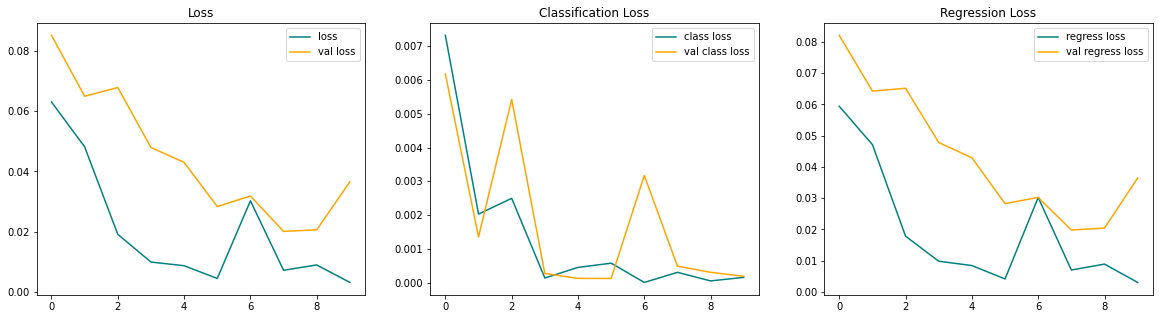

In [98]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## Testing the Model

Now that the model has been trained, we can test its performance on the unseen test dataset

In [99]:
test_data = test.as_numpy_iterator()

In [100]:
test_sample = test_data.next()

In [101]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 5s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


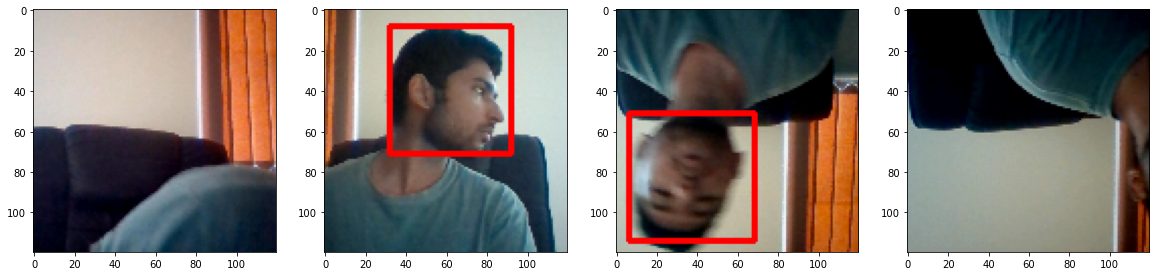

In [102]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

## Save the model

In [111]:
from tensorflow.keras.models import load_model

In [104]:
facetracker.save('facetracker_10_backup.h5')

In [112]:
#load the model
facetracker = load_model('facetracker_10.h5')

## Real Time Facial Detection Using Webcam

In [114]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:] #reducing video to 450x450- thats the augmented image size
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #convert from BGR to RGB
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0)) #scale it down
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        
        #controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        
        #controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        #controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('Facetracker', frame)
    
    if cv2.waitKey(1) == 13: 
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 2s 2s/step
